In [1]:
import pyniverse, bashthebug, copy, numpy, math, pandas, seaborn, time, random, glob, pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy import stats
from pandas.api.types import CategoricalDtype

from additional_functions import *

pandas.set_option('display.max_columns', 500)
pandas.set_option('display.max_rows', 150)

plt.rcParams.update({'font.size': 12})

%load_ext autoreload
%autoreload 2

LABORATORY_LOOKUP={'03':'A','04':'B','05':'C','06':'D','07':'E','10':'G','08':'H'}

bashthebug_colours={'red':'#dc2d4c','green':'#9ab51e','blue':'#c8e6e8'}

In [2]:
pandas.__version__

'1.3.4'

The below uses the logic for creating a consensus reading if the number of classifications ≥ threshold

```
classifications_threshold=11, valid_threshold=6
```

* remove failed readings (-20)
* if number_failed (-1 or -2) / number_remaining >= 0.5 or number_remaining < valid_threshold (6) then median == -1
* otherwise return ceil(median)


In [33]:
start=time.time()

recompute_classifications=False

PHENOTYPES=pandas.read_csv('tables/PHENOTYPES.csv.gz')   
PHENOTYPES.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

print("Loading classifications pickle...")
BASHTHEBUG=bashthebug.BashTheBugClassifications(pickle_file="tables/BASHTHEBUG_CLASSIFICATIONS_SHORT.pkl.gz",flavour='regular')

print("Creating USERS dataframe...")
BASHTHEBUG.create_users_table()

print("Creating SUMMARY dataframe...")
BASHTHEBUG.create_measurements_table(index='PLATE')

print("Creating DURATIONS dataframe...")                                               
BASHTHEBUG.create_durations_table(index='PLATE')

print("Reading previously saved dataframes...")
CLASSIFICATIONS=pandas.read_csv("tables/CLASSIFICATIONS.csv.gz",parse_dates=['CREATED_AT'])
CLASSIFICATIONS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

USERS=pandas.read_csv("tables/USERS.csv.gz")
USERS.set_index('USER_NAME',inplace=True)

SUMMARY_DILUTIONS=pandas.read_csv('tables/SUMMARY_DILUTIONS.csv.gz')
SUMMARY_DILUTIONS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

SUMMARY_DURATIONS=pandas.read_csv('tables/SUMMARY_DURATIONS.csv.gz')
SUMMARY_DURATIONS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

PLATE_LAYOUT=pandas.read_csv('tables/PLATE_LAYOUT.csv.gz')

MOD_PHENOTYPES=pandas.read_csv('tables/MOD_PHENOTYPES.csv.gz')
MOD_PHENOTYPES.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

MOD_CLASSIFICATIONS=pandas.read_csv('tables/MOD_CLASSIFICATIONS.csv.gz')   
MOD_CLASSIFICATIONS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

CONSENSUS_DATASET=pandas.read_csv('tables/CONSENSUS_DATASET.csv.gz')
CONSENSUS_DATASET.set_index(['PLATE','READINGDAY'],inplace=True)
    
print("%.1f seconds" % (time.time()-start))
print("Done!")    

Loading classifications pickle...
Creating USERS dataframe...
Creating SUMMARY dataframe...
Creating DURATIONS dataframe...
Reading previously saved dataframes...
28.4 seconds
Done!


# Image dataset

## How many strains/vials were considered?

In [35]:
PHENOTYPES.reset_index(inplace=True)
PHENOTYPES.set_index(['STRAIN','SITEID','REPLICATE'],inplace=True,verify_integrity=False)

print("A total of "+str(len(PHENOTYPES.index.unique()))+" plates were measured")

A total of 447 plates were measured


## Table S1: plates by laboratory

In [37]:
df=copy.deepcopy(PHENOTYPES)
df.reset_index(inplace=True)
df.rename(columns={'LABORATORY':'Lab','REPLICATE':'Replicate','EQA_STRAIN':'EQA strain','STRAIN':'Vial'},inplace=True)
TABLE=pandas.crosstab([df['EQA strain'],df['Vial'],df['Replicate']],df['Lab'])
TABLE.replace(70,"Y",inplace=True)
TABLE.replace(98,"Y",inplace=True)
TABLE.replace(112,"Y",inplace=True)
TABLE.replace(0,"-",inplace=True)
print(TABLE.to_latex(longtable=True,\
                     caption='List of strains and their repeats tested by laboratory.',\
                     label='table:S1',\
                     column_format='rrr|cccccccc').rstrip())

\begin{longtable}{rrr|cccccccc}
\caption{List of strains and their repeats tested by laboratory.}
\label{table:S1}\\
\toprule
      &        & Lab &  A &  B &  C &  D &  E &  G &  H \\
EQA strain & Vial & Replicate &    &    &    &    &    &    &    \\
\midrule
\endfirsthead
\caption[]{List of strains and their repeats tested by laboratory.} \\
\toprule
      &        & Lab &  A &  B &  C &  D &  E &  G &  H \\
EQA strain & Vial & Replicate &    &    &    &    &    &    &    \\
\midrule
\endhead
\midrule
\multicolumn{10}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
WHO-1 & CRY-19 & 1  &  Y &  Y &  Y &  Y &  Y &  Y &  Y \\
      &        & 2  &  Y &  Y &  Y &  Y &  Y &  Y &  Y \\
      & CRY-7 & 1  &  Y &  Y &  Y &  Y &  - &  Y &  Y \\
      &        & 2  &  Y &  Y &  Y &  Y &  - &  Y &  Y \\
WHO-10 & CRY-18 & 1  &  Y &  Y &  Y &  - &  - &  Y &  Y \\
      &        & 2  &  Y &  Y &  Y &  - &  - &  Y &  Y \\
WHO-11 & CRY-16 & 1  &  Y &  Y &  Y &  Y &  Y &  

# Project launch and progress

## The first week

Project launched on 8 April 2017 having beta-tested on 22 March 2017

In [38]:
first_week=CLASSIFICATIONS.loc[CLASSIFICATIONS.CREATED_AT<'2017-04-13']
first_week.CREATED_AT.sort_values()

PLATE             READINGDAY  DRUG
H37rV-08-0009-1   21.0        DLM     2017-03-21 12:41:25
CRY-27-08-0001-1  21.0        INH     2017-03-21 12:41:32
CRY-24-08-0002-1  14.0        CFZ     2017-03-21 12:41:40
CRY-26-08-0002-1  21.0        LEV     2017-03-21 12:41:55
CRY-21-08-0002-1  21.0        INH     2017-03-21 12:41:59
                                             ...         
CRY-30-08-0002-1  14.0        MXF     2017-04-12 23:59:21
CRY-1-08-0002-1   14.0        MXF     2017-04-12 23:59:28
CRY-3-08-0002-1   14.0        LZD     2017-04-12 23:59:43
                              RIF     2017-04-12 23:59:50
CRY-8-08-0001-1   14.0        DLM     2017-04-12 23:59:55
Name: CREATED_AT, Length: 74949, dtype: object

In [39]:
print("The beta testers did "+str(len(first_week.loc[first_week.CREATED_AT<'2017-03-23']))+" classifications")

The beta testers did 14162 classifications


In [40]:
print("By the end of the first week a total of "+str(len(first_week))+" classifications had been done")

By the end of the first week a total of 74949 classifications had been done


In [41]:
print("..by "+str(len(first_week.USER_NAME.unique()))+ " users of which "+str(len(first_week.loc[~first_week.ANONYMOUS].USER_NAME.unique()))+ " had usernames ")

..by 2029 users of which 1259 had usernames 


## First hundred days (Spiers2019)

In [42]:
FIRST_HUNDRED_DAYS=CLASSIFICATIONS.loc[(CLASSIFICATIONS.CREATED_AT>'2017-04-07') & (CLASSIFICATIONS.CREATED_AT<'2019-07-16')]
len(FIRST_HUNDRED_DAYS)

381964

In [43]:
len(FIRST_HUNDRED_DAYS.USER_NAME.unique()), len(FIRST_HUNDRED_DAYS.loc[~FIRST_HUNDRED_DAYS.ANONYMOUS].USER_NAME.unique())

(6237, 3733)

In [44]:
FIRST_HUNDRED_DAYS.loc[~FIRST_HUNDRED_DAYS.ANONYMOUS].USER_NAME.value_counts().median()

18.0

Note cannot use `user_ip` since although it might be able to tie together a single user who didn't register, equally single users can have multiple IPs.

## Figure 2 - Time series

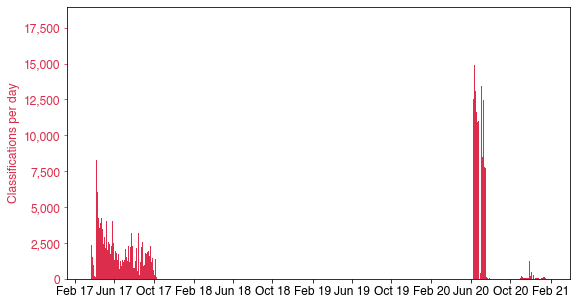

In [48]:
df=CLASSIFICATIONS[['CREATED_AT']]

# set it as the index and then re-sample
df.set_index(df.CREATED_AT,inplace=True)

BASHTHEBUG._plot_time_bar(df,sampling='day',colour='#dc2d4c',filename='pdf/graph-classifications-time-daily.pdf',add_cumulative=False,yaxis="Classifications")
# BASHTHEBUG._plot_time_bar(tmp,sampling='week',colour='#dc2d4c',filename='pdf/graph-classifications-time-weekly.pdf',add_cumulative=False,yaxis="Classifications")

In [49]:
first_set=CLASSIFICATIONS.loc[CLASSIFICATIONS.CREATED_AT<'2019-01-01'].CREATED_AT
first_set.sort_values()

PLATE             READINGDAY  DRUG
H37rV-08-0009-1   21.0        DLM    2017-03-21 12:41:25
CRY-27-08-0001-1  21.0        INH    2017-03-21 12:41:32
CRY-24-08-0002-1  14.0        CFZ    2017-03-21 12:41:40
CRY-26-08-0002-1  21.0        LEV    2017-03-21 12:41:55
CRY-21-08-0002-1  21.0        INH    2017-03-21 12:41:59
                                             ...        
CRY-14-08-0001-1  21.0        EMB    2017-10-11 18:50:07
CRY-16-03-0002-1  14.0        EMB    2017-10-11 18:50:19
CRY-30-04-0001-1  21.0        EMB    2017-10-11 18:56:17
CRY-9-07-0002-1   21.0        EMB    2017-10-11 18:56:24
H37rV-03-0002-2   21.0        BDQ    2017-12-19 17:16:45
Name: CREATED_AT, Length: 416782, dtype: datetime64[ns]

In [50]:
second_set=CLASSIFICATIONS.loc[CLASSIFICATIONS.CREATED_AT>'2019-01-01'].CREATED_AT
second_set.sort_values()

PLATE             READINGDAY  DRUG
CRY-13-10-0001-1  10.0        MXF    2020-06-08 18:17:54
H37rV-04-0005-1   10.0        MXF    2020-06-08 18:18:41
H37rV-05-0009-2   7.0         RFB    2020-06-08 18:25:27
CRY-21-04-0002-2  21.0        AMI    2020-06-08 18:25:52
CRY-3-07-0001-2   10.0        AMI    2020-06-08 18:25:59
                                             ...        
CRY-1-08-0002-1   14.0        CFZ    2021-01-19 10:34:26
CRY-25-08-0001-1  14.0        MXF    2021-01-19 10:34:33
H37rV-08-0001-1   14.0        RIF    2021-01-19 10:34:39
CRY-13-08-0002-1  14.0        MXF    2021-01-20 07:20:23
CRY-29-08-0002-1  14.0        LEV    2021-01-20 07:21:19
Name: CREATED_AT, Length: 371420, dtype: datetime64[ns]

## General description

In [51]:
print(str(len(USERS))+" volunteers participated doing a total of "+str(len(CLASSIFICATIONS))+" classifications")

print("This is a mean of %.1f each" % (len(CLASSIFICATIONS)/len(USERS)))

print("but this hides a large amount of variation in the number of classifications done by individual volunteers")

print("So, "+str(len(USERS.loc[USERS.CLASSIFICATIONS==1]))+" volunteers only did 1 classification and "+str(len(USERS.loc[USERS.CLASSIFICATIONS<=10]))+" did ten or fewer")

9372 volunteers participated doing a total of 788202 classifications
This is a mean of 84.1 each
but this hides a large amount of variation in the number of classifications done by individual volunteers
So, 1115 volunteers only did 1 classification and 4299 did ten or fewer


In [52]:
print("By contrast, the ten volunteers who participated the most did %i classifications between them which is %.1f %% of the total " % (USERS[-10:].CLASSIFICATIONS.sum(),100*USERS[-10:].CLASSIFICATIONS.sum()/len(CLASSIFICATIONS)))

By contrast, the ten volunteers who participated the most did 103569 classifications between them which is 13.1 % of the total 


## Figure 2 - Gini coefficient

In [53]:
print("%.3f" % (BASHTHEBUG.gini_coefficient))

0.852


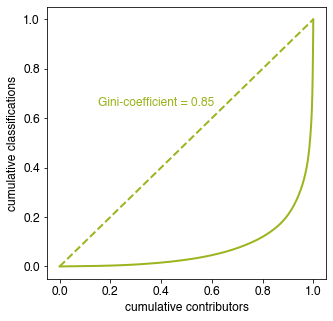

In [54]:
BASHTHEBUG.plot_user_classification_distribution(filename="pdf/graph-users-gini.pdf")

## Figure S2 - classifications per image

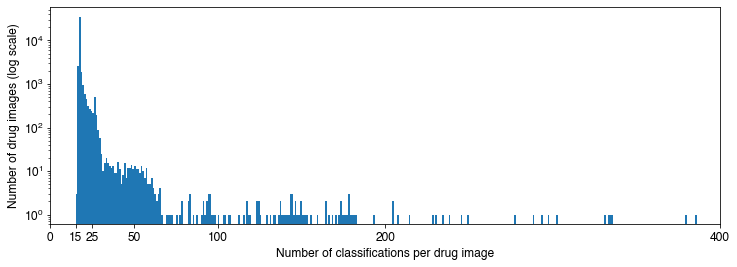

In [55]:
graph,axes=plt.subplots(1,1,figsize=(12,4))
a=axes.hist(SUMMARY_DILUTIONS.COUNT,bins=numpy.arange(0,400,1),density=False,cumulative=False)  
axes.set_yscale('log')
axes.set_xticks([0,15,25,50,100,200,400]) 
axes.set_xlim([0,400]) 
axes.set_xlabel('Number of classifications per drug image')
axes.set_ylabel('Number of drug images (log scale)')
graph.savefig('pdf/hist-classifications-per-image.pdf')

## Task duration

How does the mean time taken as we exclude different bits of the tail?

In [56]:
for i in [30, 60, 100,200,300,600,1800,3600,7200]:
    print ("%5i %8i %.1f" % (i, numpy.sum(CLASSIFICATIONS.TASK_DURATION>i), CLASSIFICATIONS.loc[CLASSIFICATIONS.TASK_DURATION<i].TASK_DURATION.mean()))

   30    56017 7.3
   60    30496 8.4
  100    20997 9.3
  200    11979 10.8
  300     7986 12.0
  600     4593 13.7
 1800     2406 16.4
 3600     1592 19.1
 7200     1099 22.2


## Figure 2, S3 task duration by reading day

In [57]:
CLASSIFICATIONS.reset_index(inplace=True)

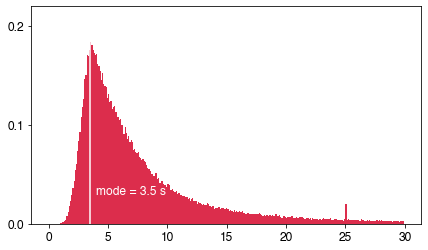

In [58]:
colour_lookup={ 14:'#dc2d4c',\
                 7:'#9ab51e',\
                10:'#c8e6e8',\
                21:'#9ab51e' }


for reading_day in [7,10,14,21]:

    path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / 'duration'
    path.mkdir(parents=True,exist_ok=True)
    
    df=copy.deepcopy(CLASSIFICATIONS.loc[CLASSIFICATIONS.READINGDAY==reading_day])
    
    graph,axes=plt.subplots(1,1,figsize=(7,4))
    a=axes.hist(df.TASK_DURATION,bins=numpy.arange(0,30,0.1),density=True,color=colour_lookup[reading_day])    
    axes.set_ylim([0,0.22])
    axes.set_yticks([0,0.1,0.2])
    
    df['TASK_DURATION_BIN']=pandas.cut(df.TASK_DURATION,bins=numpy.arange(0,30,0.1),labels=False,retbins=False)
    duration_mode=df.TASK_DURATION_BIN.mode()/10
    if len(duration_mode)>1:
        duration_mode=duration_mode[0]
    axes.plot([duration_mode,duration_mode],[0,0.2],color='white')
    axes.text(duration_mode+0.5,0.03,"mode = "+str(float(duration_mode))+" s",color='white',weight='bold')

    graph.savefig(path / 'hist-task-duration.pdf')
    
    if reading_day!=14:
        plt.close()

## Figure S4 - Task duration by drug after 14 days of incubation

In [59]:
colours=['#dc2d4c','#9ab51e','#c8e6e8']

counter=0

path=pathlib.Path.cwd() / 'pdf' / '14' / 'duration'
path.mkdir(parents=True,exist_ok=True)

for drug in tqdm(PLATE_LAYOUT.DRUG.unique()):
    
    if drug=='POS':
        continue 
        
    df=copy.deepcopy(CLASSIFICATIONS.loc[(CLASSIFICATIONS.READINGDAY==14) & (CLASSIFICATIONS.DRUG==drug)])
    
    graph,axes=plt.subplots(1,1,figsize=(7,4))
    a=axes.hist(df.TASK_DURATION,bins=numpy.arange(0,30,0.1),density=True,color=colours[counter % 3])    
    axes.set_ylim([0,0.25])
    axes.set_yticks([0,0.1,0.2])
    
    df['TASK_DURATION_BIN']=pandas.cut(df.TASK_DURATION,bins=numpy.arange(0,30,0.2),labels=False,retbins=False)
    duration_mode=df.TASK_DURATION_BIN.mode()/5
    if len(duration_mode)>1:
        duration_mode=duration_mode[0]
    axes.plot([duration_mode,duration_mode],[0,0.2],color='white')
    axes.text(duration_mode+0.5,0.03,"mode = "+str(float(duration_mode))+" s",color='white',weight='bold')
    axes.text(28,0.2,drug,color=colours[counter%3])
    counter+=1

    filename='hist-task-duration-'+drug+'.pdf'
    
    graph.savefig(path / filename)
    
    plt.close()

100%|███████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s]


In [60]:
numpy.sum(SUMMARY_DILUTIONS.COUNT>=34),numpy.sum(SUMMARY_DILUTIONS.COUNT>=100)

(421, 89)

In [61]:
SUMMARY_DILUTIONS.COUNT.count()

43671

# Table S2

In [62]:
a=pandas.cut(SUMMARY_DILUTIONS.COUNT,\
               bins=[0,14,15,16,17,18,19,20,22,25,30,40,50,75,100,150,200,300,500],\
               labels=["n $\le$ 14","15","16","17","18","19","20","21 or 22","23, 24 or 25","25 $<$ n $<$ 29","30 $<$ n $<$ 39","40 $<$ n $<$ 49",\
                       "50 $<$ n $<$ 74","75 $<$ n $<$ 99","100 $<$ n $<$ 149","150 $<$ n $<$ 199","200 $<$ n $<$ 299","300 $<$ n $<$ 499"],\
            right=True).value_counts().sort_index()

TABLE=a.to_frame()
TABLE.reset_index(inplace=True)
TABLE.rename(columns={'index':'Classifications performed by volunteers','COUNT':'Number of drug images'},inplace=True)

total=SUMMARY_DILUTIONS.COUNT.count()

def calc_prop(row):
    return("%.1f" % (100*row['Number of drug images']/total))

TABLE['Proportion of drug images']=TABLE.apply(calc_prop,axis=1)

print("\\begin{table}\n\\begin{center}")
print(TABLE.to_latex(index=False,escape=False).rstrip())
print("\\caption[The number of classifications performed for each drug image]{\\label{table:S2} The number of classifications performed for each drug image. The retirement limit on the Zooniverse platform was set to 17, however, a subset of images recieved many more classifications. }")
print("\\end{center}\n\\end{table}\n")

\begin{table}
\begin{center}
\begin{tabular}{lrl}
\toprule
Classifications performed by volunteers &  Number of drug images & Proportion of drug images \\
\midrule
                             n $\le$ 14 &                      0 &                       0.0 \\
                                     15 &                      3 &                       0.0 \\
                                     16 &                   2659 &                       6.1 \\
                                     17 &                  34843 &                      79.8 \\
                                     18 &                   1841 &                       4.2 \\
                                     19 &                    924 &                       2.1 \\
                                     20 &                    601 &                       1.4 \\
                               21 or 22 &                    760 &                       1.7 \\
                           23, 24 or 25 &                    720 &  

## Figure 3 - Example drug images

This is a bit hacky, but create a textfile of `cp` commands to add 10 samples randomly but reproducibly chosen for each (bashthebug,truth_set_1) coordinate to `DropBox`

In [33]:
create_copy_script=False

if create_copy_script:

    OUTPUT=open('copy-example-drug-images.sh','w')

    for ix in range(0,10):
        for iy in range(0,10):
            df=MOD_CLASSIFICATIONS.loc[(MOD_CLASSIFICATIONS.BASHTHEBUG_DILUTION==ix) & (MOD_CLASSIFICATIONS.TRUTH_SET_3==iy)]
            if not df.empty and len(df)>10:
                subset=df.sample(n=10,random_state=42)
                for i,row in subset.iterrows():
                    path=pathlib.Path.cwd() / 'drug-images' / str(iy) / str(ix)
                    path.mkdir(parents=True,exist_ok=True)
                    OUTPUT.write("cp "+row['PATH']+" drug-images/"+str(iy)+"/"+str(ix)+'/\n')

    OUTPUT.close()        

## Figure S5 - growth histograms

In [64]:
CONSENSUS_DATASET.reset_index(inplace=True)

TRUTH_SET_1 mean growth is 30.6 % 
MEDIUM    0.783902
HIGH      0.140454
LOW       0.075644
Name: GROWTH, dtype: float64
TRUTH_SET_3 mean growth is 30.4 % 
MEDIUM    0.779180
HIGH      0.139956
LOW       0.080864
Name: GROWTH, dtype: float64
TRUTH_SET_2 mean growth is 30.4 % 
MEDIUM    0.782060
HIGH      0.138247
LOW       0.079693
Name: GROWTH, dtype: float64


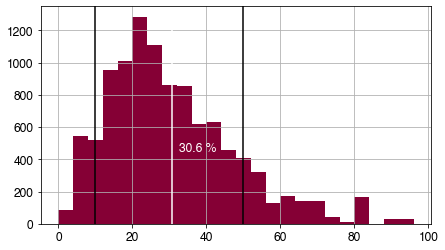

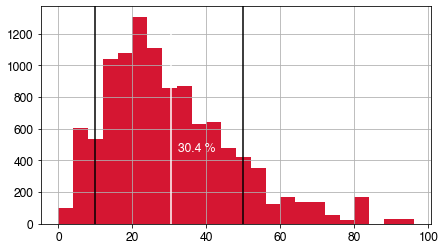

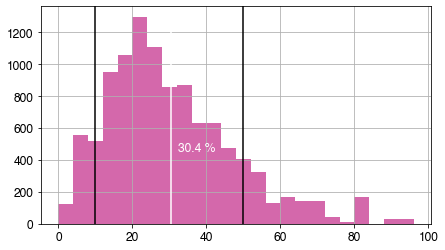

In [65]:
truth_colors={'TRUTH_SET_1':'#850035',\
              'TRUTH_SET_3':'#d51632',\
              'TRUTH_SET_2':'#d468ab' }


for i in truth_colors.keys():
   
    df=copy.deepcopy(CONSENSUS_DATASET.loc[(CONSENSUS_DATASET[i]!=0) &\
                          (CONSENSUS_DATASET.READINGDAY==14) & \
                          (CONSENSUS_DATASET.BOOTSTRAP_RUN==0) &\
                          (CONSENSUS_DATASET.N_CLASSIFICATIONS==3)] )

    fig,axes=plt.subplots(1,1,figsize=(7,4))
    axes=df.IM_POS_AVERAGE.hist(bins=numpy.arange(0,100,4),color=truth_colors[i])
    mean_growth=df.IM_POS_AVERAGE.mean()
    max_y=numpy.max(axes.get_ylim())
    axes.plot((mean_growth,mean_growth),(0,max_y),color='white')
    axes.text(mean_growth+2,max_y/3,'%.1f %%' % (mean_growth),color='white')
    axes.plot((10,10),(0,max_y),color='black')
    axes.plot((50,50),(0,max_y),color='black')
    axes.set_ylim([0,max_y])
    print("%s mean growth is %.1f %% " % (i,df.IM_POS_AVERAGE.mean()))
    print(df.GROWTH.value_counts(normalize=True))
    path=pathlib.Path.cwd() / 'pdf' / '14' / 'growth'
    filename='hist-14-'+i.lower()+'-growth.pdf'
    path.mkdir(parents=True,exist_ok=True)
    fig.savefig(path/filename,bbox_inches=0)



## Figure 3, S7, S8 - raw heatmaps and dilution distributions

In [35]:
MOD_PHENOTYPES.reset_index(inplace=True)
MOD_CLASSIFICATIONS.reset_index(inplace=True)


truth_set_1 after  7 days contains  12502 measurements and 160102 classifications


<ipython-input-36-ad4d303e0393>:70: RuntimeWarning: invalid value encountered in long_scalars
  agreement_with_expert=[100*grid[i][i]/numpy.sum(grid[i,0:]) for i in range(0,10)]


truth_set_1 after 10 days contains  12474 measurements and 177315 classifications
truth_set_1 after 14 days contains  12488 measurements and 206353 classifications
truth_set_1 after 21 days contains  12474 measurements and 186624 classifications
truth_set_2 after  7 days contains   9744 measurements and 123416 classifications


<ipython-input-36-ad4d303e0393>:70: RuntimeWarning: invalid value encountered in long_scalars
  agreement_with_expert=[100*grid[i][i]/numpy.sum(grid[i,0:]) for i in range(0,10)]


truth_set_2 after 10 days contains   9336 measurements and 130273 classifications
truth_set_2 after 14 days contains   9402 measurements and 153929 classifications
truth_set_2 after 21 days contains  10369 measurements and 155204 classifications
truth_set_3 after  7 days contains   5598 measurements and  80197 classifications


<ipython-input-36-ad4d303e0393>:70: RuntimeWarning: invalid value encountered in long_scalars
  agreement_with_expert=[100*grid[i][i]/numpy.sum(grid[i,0:]) for i in range(0,10)]


truth_set_3 after 10 days contains   5662 measurements and  85912 classifications
truth_set_3 after 14 days contains   6205 measurements and 112163 classifications
truth_set_3 after 21 days contains   6394 measurements and 106144 classifications


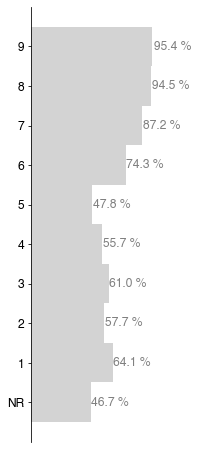

In [36]:
table=[]
pullout_images={}

categorical_dilutions = CategoricalDtype(categories=range(10), ordered=True)

MOD_CLASSIFICATIONS['BASHTHEBUG_DILUTION']=MOD_CLASSIFICATIONS['BASHTHEBUG_DILUTION'].astype(categorical_dilutions)

for truth_set in ['TRUTH_SET_1','TRUTH_SET_2','TRUTH_SET_3']:

    MOD_PHENOTYPES[truth_set]=MOD_PHENOTYPES[truth_set].astype(categorical_dilutions)
    MOD_CLASSIFICATIONS[truth_set]=MOD_CLASSIFICATIONS[truth_set].astype(categorical_dilutions)
    
    for reading_day in [7,10,14,21]:
       
        # subset down to the only those in the truth set
        df=MOD_PHENOTYPES.loc[(MOD_PHENOTYPES[truth_set].notna()) & (MOD_PHENOTYPES.READINGDAY==reading_day)]    

        # plot the distribution
        plot_classifications_hist(df[truth_set],
                                  reading_day,
                                  'accuracy', 
                                  truth_set.lower(),
                                  'all',
                                  'all',
                                  'dilution-2',
                                  bashthebug_colours['red'])           
        
        plot_classifications_hist(df[truth_set],
                                  reading_day,
                                  'accuracy', 
                                  truth_set.lower(),
                                  'all',
                                  'all',
                                  'dilution-1',
                                  truth_colors[truth_set])    

        # now join the raw classifications so we can look at classification variability
        df2=MOD_CLASSIFICATIONS.loc[(MOD_CLASSIFICATIONS[truth_set].notna()) & (MOD_CLASSIFICATIONS.READINGDAY==reading_day) & (MOD_CLASSIFICATIONS.DRUG!='PAS')]    

        plot_classifications_hist(df2['BASHTHEBUG_DILUTION'],
                          reading_day,
                          'accuracy',        
                          truth_set.lower(),
                          'all',
                          'all',
                          'bashthebug-1',
                          bashthebug_colours['green'],orientation='horizontal')    
        
        print(truth_set.lower()+" after %2i days contains %6i measurements and %6i classifications" % (reading_day,len(df),len(df2)))
        
        
        
        # plot the heatmap
        grid=pandas.crosstab(df2[truth_set],df2['BASHTHEBUG_DILUTION'],normalize=True,dropna=False)
        plot_heatmap(grid,\
                     reading_day,
                     'accuracy',
                     truth_set.lower(),
                     'all',
                     'all',    
                     None,
                     'all',
                     vmax=30)
        row=[truth_set,reading_day,len(df),len(df2)]

        grid=pandas.crosstab(df2[truth_set],df2['BASHTHEBUG_DILUTION'],normalize=False,dropna=False)

        grid=numpy.array(grid)
        assert grid.shape==(10,10), 'grid has shape '+str(grid.shape)
        agreement_with_expert=[100*grid[i][i]/numpy.sum(grid[i,0:]) for i in range(0,10)]
        
        fig,axes=plt.subplots(1,1,figsize=(2.5,8))
        y=numpy.arange(0,10)
        height=1
        rects1=axes.barh(y,numpy.nan_to_num(agreement_with_expert),color='lightgrey',height=height)
        axes.set_yticks(y)
        y_range=axes.get_ylim()
        axes.set_ylim(y_range)
        axes.set_yticklabels(['NR']+[i for i in range(1,10)])
        axes.set_xlim((0,110))
        axes.spines['right'].set_visible(False)
        axes.spines['top'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.set_xticks([])

        def autolabel(rects):
            """
            Attach a text label above each bar displaying its height
            """
            for rect in rects:
                height = rect.get_width()
                axes.text(1.01*height, rect.get_y() + rect.get_height()/2.,
                        '%.1f %%' % height,
                        ha='left', va='center',color='grey')

        autolabel(rects1)

        fig.savefig('pdf/'+str(reading_day)+'/accuracy/'+truth_set.lower()+'/all/all/bar-'+str(reading_day)+'-accuracy-'+truth_set.lower()+'-all-expert-agreement.pdf')
        
        if truth_set=='TRUTH_SET_3' and reading_day==14:
            pass
        else:
            plt.close()
    
       
        # update the row and add to the table
        row+=calculate_grid_metrics(grid)
        table.append(row)

        
RAW_SUMMARY=pandas.DataFrame(table,columns=['TRUTH_SET','READINGDAY','N_MEASUREMENTS','N_CLASSIFICATIONS',\
                                        'N','DIAGONAL','UPPER_DIAGONAL','LOWER_DIAGONAL','UPPER_TRIANGLE',\
                                        'LOWER_TRIANGLE','BOTH_NR','TRUTH_OK_METHOD_NR',\
                                        'TRUTH_NR_METHOD_OK','INNER_SQUARE'])

RAW_SUMMARY['ESSENTIAL_AGREEMENT']=100*(RAW_SUMMARY['DIAGONAL']+\
                                              RAW_SUMMARY['UPPER_DIAGONAL']+\
                                              RAW_SUMMARY['LOWER_DIAGONAL'])/RAW_SUMMARY['INNER_SQUARE']

RAW_SUMMARY['EXACT_AGREEMENT']=100*RAW_SUMMARY['DIAGONAL']/RAW_SUMMARY['INNER_SQUARE']        

## Table S3 - truth datasets

In [37]:
table=copy.deepcopy(RAW_SUMMARY)
table=table[['READINGDAY','TRUTH_SET','N_MEASUREMENTS', 'N_CLASSIFICATIONS','ESSENTIAL_AGREEMENT','EXACT_AGREEMENT']]
table.replace({'TRUTH_SET':{'TRUTH_SET_1':'Expert',\
                            'TRUTH_SET_2':'Expert+mirrored-box',\
                            'TRUTH_SET_3':'Expert+AMyGDA'}},inplace=True)
table['TRUTH_SET']=pandas.Categorical(table['TRUTH_SET'],['Expert+AMyGDA','Expert','Expert+mirrored-box'])
table=table.loc[table.TRUTH_SET!='Expert+mirrored-box']
table.sort_values(by=['READINGDAY','TRUTH_SET'],inplace=True)
table.set_index(['READINGDAY','TRUTH_SET'],inplace=True)
table.index.names=(['Reading day','Reference dataset'])

print("\\begin{table}\n\\begin{center}")
print(table.to_latex(float_format='%.1f %%',\
                     column_format='c|crrrr',\
               escape=True,\
               index=True,\
               multirow=True,\
                     multicolumn=True,\
               header=['Measurements','Classifications','Essential agreement','Exact agreement']).rstrip())
print("\\caption[Individual volunteers only agree with the Expert+AMyGDA reference dataset in 60-70\% of drug images.]{\\label{table:S3} Individual volunteers only agree with the Expert+AMyGDA reference dataset in 60-70\% of drug images. The exact and essential agreement between individual volunteers and the reference Expert+AMyGDA dataset improves with the length of incubation. The Expert dataset is shown for comparision. }")
print("\\end{center}\n\\end{table}\n")

#                header=['Reading day','Expert dataset','Measurements','Classifications','Essential agreement','Exact agreement']).rstrip())


\begin{table}
\begin{center}
\begin{tabular}{c|crrrr}
\toprule
   &        & Measurements & Classifications & Essential agreement & Exact agreement \\
Reading day & Reference dataset &              &                 &                     &                 \\
\midrule
\multirow{2}{*}{7} & Expert+AMyGDA &         5598 &           80197 &              85.2 \% &          68.7 \% \\
   & Expert &        12502 &          160102 &              81.7 \% &          59.9 \% \\
\cline{1-6}
\multirow{2}{*}{10} & Expert+AMyGDA &         5662 &           85912 &              86.1 \% &          73.1 \% \\
   & Expert &        12474 &          177315 &              82.7 \% &          63.2 \% \\
\cline{1-6}
\multirow{2}{*}{14} & Expert+AMyGDA &         6205 &          112163 &              86.4 \% &          74.6 \% \\
   & Expert &        12488 &          206353 &              83.3 \% &          65.3 \% \\
\cline{1-6}
\multirow{2}{*}{21} & Expert+AMyGDA &         6394 &          106144 &              8

## Table S4 - Expert and AMyGDA agreement by dilution

In [38]:
MOD_PHENOTYPES['IN_TRUTH_SET_3']=(MOD_PHENOTYPES.TRUTH_SET_3>=0)
table=copy.deepcopy(MOD_PHENOTYPES[['VZ','IN_TRUTH_SET_3']].groupby('VZ').agg([numpy.mean,stats.sem]))
table.columns=table.columns.droplevel()
def return_formatted_values(row):
    return("%.1f $\pm$ %.1f %%"% (100*row[('mean')],100*row[('sem')]))
table[['Agreement']]=table.apply(return_formatted_values,axis=1)
table.reset_index(inplace=True)
table.rename(columns={'VZ':'Dilution'},inplace=True)
table.Dilution=table.Dilution.astype(int)
table.replace({'Dilution':{0:'NR'}},inplace=True)
table=table[['Dilution','Agreement']]

print("\\begin{table}\n\\begin{center}")
print(table.to_latex(float_format='%.1f %',\
                     column_format='r|r',\
               escape=False,\
               index=False).rstrip())
print("\\caption[The Expert and AMyGDA MICs are more likely to concur at smaller dilutions. The standard error of the mean is given.]{\\label{table:S4} The Expert and AMyGDA MICs are more likely to concur at smaller dilutions.}")
print("\\end{center}\n\\end{table}\n")

\begin{table}
\begin{center}
\begin{tabular}{r|r}
\toprule
Dilution &        Agreement \\
\midrule
      NR & 43.9 $\pm$ 0.6 % \\
       1 & 76.3 $\pm$ 0.4 % \\
       2 & 43.5 $\pm$ 0.5 % \\
       3 & 29.1 $\pm$ 0.6 % \\
       4 & 31.4 $\pm$ 0.8 % \\
       5 & 29.9 $\pm$ 0.8 % \\
       6 & 31.6 $\pm$ 0.8 % \\
       7 & 39.3 $\pm$ 1.0 % \\
       8 & 52.6 $\pm$ 1.0 % \\
       9 & 16.1 $\pm$ 2.6 % \\
\bottomrule
\end{tabular}
\caption[The Expert and AMyGDA MICs are more likely to concur at smaller dilutions.]{\label{table:S4} The Expert and AMyGDA MICs are more likely to concur at smaller dilutions.}
\end{center}
\end{table}



## Figure 3,4 - Reproducibility and Truth Sets

Here we try different bootstraps against one another and the truth sets, calculating and storing the key metrics each time, but only plotting the overall heatmap.

The below takes about 52 min to run on `lambda`

In [39]:
CONSENSUS_DATASET.reset_index(inplace=True)

In [40]:
calculate_consensus_summary=False

total_bootstraps=20

start=time.time()

summary_grid={}

zero_grid=numpy.zeros((10,10))

if not calculate_consensus_summary:

    CONSENSUS_SUMMARY=pandas.read_pickle('tables/CONSENSUS_SUMMARY.pkl.gz')
    CONDENSED_SUMMARY=pandas.read_pickle('tables/CONDENSED_SUMMARY.pkl.gz')
    
else:
    
    for method in ['MEDIAN','MEAN','MODE']:
        CONSENSUS_DATASET[method+"CEIL"]=CONSENSUS_DATASET[method].apply(numpy.floor).astype('category')

    for truth_set in ['TRUTH_SET_1','TRUTH_SET_2','TRUTH_SET_3']:
        CONSENSUS_DATASET[truth_set]=CONSENSUS_DATASET[truth_set].astype('category')
    
    n_bootstraps=len(CONSENSUS_DATASET.BOOTSTRAP_RUN.unique())

    BASE_NUMBER=3

    df=copy.deepcopy(CONSENSUS_DATASET.loc[   (CONSENSUS_DATASET.N_CLASSIFICATIONS==BASE_NUMBER) &\
                                (CONSENSUS_DATASET.STDDEV==0) ])

    df.set_index(['PLATE','DRUG','READINGDAY','BOOTSTRAP_RUN'],inplace=True)
    df[['HAS_ZERO_STDDEV']]=True
    df=df[['HAS_ZERO_STDDEV']]

    CONSENSUS_DATASET.set_index(['PLATE','DRUG','READINGDAY','BOOTSTRAP_RUN'],inplace=True)
    CONSENSUS_DATASET=CONSENSUS_DATASET.join(df,how='left')
    CONSENSUS_DATASET['HAS_ZERO_STDDEV'].fillna(False,inplace=True)
    CONSENSUS_DATASET.reset_index(inplace=True)
        
    boot={}
    samples={}
    table=[]
    condensed_table=[]
    
    for reading_day in tqdm(CONSENSUS_DATASET.READINGDAY.unique()):
        
        if reading_day==14:
            growth_list=['ALL','HIGH','LOW','MEDIUM']
        else:
            growth_list=['ALL']

        for n_classifications in tqdm(CONSENSUS_DATASET.N_CLASSIFICATIONS.unique()):
            
            for growth in growth_list:
                
                if growth=='ALL' and reading_day==14:
                    drug_list=['ALL', 'AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'PAS', 'RFB', 'RIF']
                    stddev_list = ['ALL','ZERO','NOT_ZERO']
                else:
                    drug_list=['ALL']
                    stddev_list = ['ALL']
                    
                for stddev in stddev_list:
                    
                    for drug in drug_list:

                        # setup an empty dataset which may be overwritten
                        CONSENSUS_DATASET_SUBSET=pandas.DataFrame([])
                        
                        # subset down the consensus
                        if drug=='ALL':

                            if growth=='ALL':

                                if stddev=='ALL':

                                    CONSENSUS_DATASET_SUBSET=CONSENSUS_DATASET.loc[(CONSENSUS_DATASET.READINGDAY==reading_day) &\
                                                                                   (CONSENSUS_DATASET.N_CLASSIFICATIONS==n_classifications) &\
                                                                                   (CONSENSUS_DATASET.DRUG!='PAS')]
                                elif stddev=='ZERO':

                                    CONSENSUS_DATASET_SUBSET=CONSENSUS_DATASET.loc[(CONSENSUS_DATASET.READINGDAY==reading_day) &\
                                                                                   (CONSENSUS_DATASET.N_CLASSIFICATIONS==n_classifications) &\
                                                                                   (CONSENSUS_DATASET.DRUG!='PAS') &\
                                                                                   (CONSENSUS_DATASET.HAS_ZERO_STDDEV)]
                                elif stddev=='NOT_ZERO':

                                    CONSENSUS_DATASET_SUBSET=CONSENSUS_DATASET.loc[(CONSENSUS_DATASET.READINGDAY==reading_day) &\
                                                                                   (CONSENSUS_DATASET.N_CLASSIFICATIONS==n_classifications) &\
                                                                                   (CONSENSUS_DATASET.DRUG!='PAS') &\
                                                                                   (~CONSENSUS_DATASET.HAS_ZERO_STDDEV)]
                                else:
                                    raise ValueError('value of stddev not recognised!',stddev)

                                    
                            elif growth in ['LOW','MEDIUM','HIGH']:
                                
                                if stddev=='ALL':

                                    CONSENSUS_DATASET_SUBSET=CONSENSUS_DATASET.loc[(CONSENSUS_DATASET.READINGDAY==reading_day) &\
                                                                                    (CONSENSUS_DATASET.N_CLASSIFICATIONS==n_classifications) &\
                                                                                    (CONSENSUS_DATASET.DRUG!='PAS') &\
                                                                                    (CONSENSUS_DATASET.GROWTH==growth)]                                        
                                else:
                                    continue


                            CONSENSUS_DATASET_SUBSET.set_index(['PLATE','DRUG'],inplace=True)

                        else:                    

                            if growth=='ALL':
                                
                                if stddev=='ALL':

                                    CONSENSUS_DATASET_SUBSET=CONSENSUS_DATASET.loc[(CONSENSUS_DATASET.READINGDAY==reading_day) &\
                                                                                   (CONSENSUS_DATASET.N_CLASSIFICATIONS==n_classifications) &\
                                                                                   (CONSENSUS_DATASET.DRUG==drug)]
                                else:
                                    
                                    continue
                                    
                            else:
                                
                                continue


                            CONSENSUS_DATASET_SUBSET.set_index('PLATE',inplace=True)

                        if CONSENSUS_DATASET_SUBSET.empty:
                            continue

                        # loop over the three methods
                        for method in ['MEDIAN','MEAN','MODE']:

                            # intialise the heatmap array
                            summary_grid[method]=numpy.zeros((10,10))

                        for truth_set in ['TRUTH_SET_1','TRUTH_SET_2','TRUTH_SET_3']:

                            # tackle reproducibility first by creating pairs of bootstraps
                            for n_boot in range(total_bootstraps):

                                # choose two bootstrap runs without replacement
                                boot=random.sample(list(CONSENSUS_DATASET_SUBSET.BOOTSTRAP_RUN.unique()),2)

                                # use these to pick out the two sets to compare
                                for i in [0,1]:

                                    samples[i]=copy.deepcopy(CONSENSUS_DATASET_SUBSET.loc[(CONSENSUS_DATASET_SUBSET.BOOTSTRAP_RUN==boot[i]) &\
                                                                                          (CONSENSUS_DATASET_SUBSET[truth_set]!=0)])

                                    for method in ['MEDIAN','MEAN','MODE']:

                                        # rename the columns so we can join
                                        samples[i].rename(columns={method+"CEIL":method+str(i)},inplace=True)

                                if samples[0].empty or samples[1].empty:
                                    continue

                                # join back 
                                df=samples[0][['MEAN0','MEDIAN0','MODE0']].join(samples[1][['MEAN1','MEDIAN1','MODE1']])

                                for method in ['MEDIAN','MEAN','MODE']:

                                    # form a cross-tabulation
                                    grid=pandas.crosstab(df[method+"0"],df[method+"1"],normalize=False,dropna=False)

                                    if grid.empty:
                                        continue

                                    # start the table row
                                    row=[truth_set,'REPRODUCIBILITY',reading_day,stddev,growth,drug,n_classifications,n_boot,method]

                                    grid=numpy.array(grid)                                   
                                    assert grid.shape==(10,10)

                                    # update the row and add to the table
                                    row+=calculate_grid_metrics(grid)                        
                                    table.append(row)

                                    # update the overall crosstab
                                    summary_grid[method]+=grid

                            for method in ['MEDIAN','MEAN','MODE']:
                                summary_grid[method]/=int(n_bootstraps/2)
                                
                                row=[truth_set,'REPRODUCIBILITY',reading_day,stddev,growth,drug,n_classifications,n_boot,method]
                                row+=calculate_grid_metrics(summary_grid[method])                        
                                condensed_table.append(row)
                                
                                if numpy.sum(summary_grid[method])==0:
                                    continue
                                summary_grid[method]=summary_grid[method]/numpy.sum(summary_grid[method])

                                label=(drug.lower() if stddev=='ALL' else drug.lower()+'-'+stddev.lower())
                                                                        
                                plot_heatmap(summary_grid[method],\
                                                 reading_day,\
                                                 'reproducibility',\
                                                 truth_set.lower(),\
                                                 n_classifications,
                                                 growth.lower(),\
                                                 method.lower(),\
                                                 label,\
                                                 exclude_nr=True,vmax=40)            

                            for method in ['MEDIAN','MEAN','MODE']:
                                summary_grid[method]=numpy.zeros((10,10))

                            for n_boot in range(total_bootstraps):
                                
                                boot=random.sample(list(CONSENSUS_DATASET_SUBSET.BOOTSTRAP_RUN.unique()),1)

                                # pick out the set to compare
                                sample_set=copy.deepcopy(CONSENSUS_DATASET_SUBSET.loc[CONSENSUS_DATASET_SUBSET.BOOTSTRAP_RUN==n_boot])

                                for method in ['MEDIAN','MEAN','MODE']:

                                    # form a cross-tabulation
                                    grid=pandas.crosstab(sample_set[method+"CEIL"],sample_set[truth_set],normalize=False,dropna=False)

                                    if grid.empty:
                                        continue

                                    # start the table row
                                    row=[truth_set,'ACCURACY',reading_day,stddev,growth,drug,n_classifications,n_boot,method]

                                    grid=numpy.array(grid)                                    
                                    assert grid.shape==(10,10)

                                    # update the row and add to the table
                                    row+=calculate_grid_metrics(grid)
                                    table.append(row)

                                    # update the overall crosstab
                                    summary_grid[method]+=grid

                            for method in ['MEDIAN','MEAN','MODE']:
                                summary_grid[method]/=n_bootstraps  
                                
                                row=[truth_set,'ACCURACY',reading_day,stddev,growth,drug,n_classifications,n_boot,method]
                                row+=calculate_grid_metrics(summary_grid[method])                        
                                condensed_table.append(row)                                
                                
                                if numpy.sum(summary_grid[method])==0:
                                    print(row)
                                    continue
                                summary_grid[method]=summary_grid[method]/numpy.sum(summary_grid[method])

                                label=(drug.lower() if stddev=='ALL' else drug.lower()+'-'+stddev.lower())
                                
                                plot_heatmap(summary_grid[method],\
                                             reading_day,\
                                             'accuracy',\
                                             truth_set.lower(),\
                                             n_classifications,
                                             growth.lower(),\
                                             method.lower(),\
                                             label,
                                             exclude_nr=True,vmax=40)            


    CONSENSUS_SUMMARY=pandas.DataFrame(table,columns=['TRUTH_SET','TYPE','READINGDAY','STDDEV','GROWTH','DRUG','N_CLASSIFICATIONS','BOOTSTRAP_RUN','METHOD',\
                                            'N','DIAGONAL','UPPER_DIAGONAL','LOWER_DIAGONAL','UPPER_TRIANGLE',\
                                            'LOWER_TRIANGLE','BOTH_NR','TRUTH_OK_METHOD_NR',\
                                            'TRUTH_NR_METHOD_OK','INNER_SQUARE'])

    CONSENSUS_SUMMARY['TRUTH_OK']=CONSENSUS_SUMMARY['TRUTH_OK_METHOD_NR']+CONSENSUS_SUMMARY['INNER_SQUARE']
    CONSENSUS_SUMMARY['PROP_READ']=100*CONSENSUS_SUMMARY['INNER_SQUARE']/CONSENSUS_SUMMARY['TRUTH_OK']
    
    CONSENSUS_SUMMARY['ESSENTIAL_AGREEMENT']=100*(CONSENSUS_SUMMARY['DIAGONAL']+\
                                                  CONSENSUS_SUMMARY['UPPER_DIAGONAL']+\
                                                  CONSENSUS_SUMMARY['LOWER_DIAGONAL'])/CONSENSUS_SUMMARY['INNER_SQUARE']

    CONSENSUS_SUMMARY['EXACT_AGREEMENT']=100*(CONSENSUS_SUMMARY['DIAGONAL']/CONSENSUS_SUMMARY['INNER_SQUARE'])

    CONSENSUS_SUMMARY.to_pickle('tables/CONSENSUS_SUMMARY.pkl.gz')
    CONSENSUS_SUMMARY.to_csv('tables/CONSENSUS_SUMMARY.csv.gz')

    
    CONDENSED_SUMMARY=pandas.DataFrame(condensed_table,columns=['TRUTH_SET','TYPE','READINGDAY','STDDEV','GROWTH','DRUG','N_CLASSIFICATIONS','BOOTSTRAP_RUN','METHOD',\
                                            'N','DIAGONAL','UPPER_DIAGONAL','LOWER_DIAGONAL','UPPER_TRIANGLE',\
                                            'LOWER_TRIANGLE','BOTH_NR','TRUTH_OK_METHOD_NR',\
                                            'TRUTH_NR_METHOD_OK','INNER_SQUARE'])

    CONDENSED_SUMMARY['TRUTH_OK']=CONDENSED_SUMMARY['TRUTH_OK_METHOD_NR']+CONDENSED_SUMMARY['INNER_SQUARE']
    CONDENSED_SUMMARY['PROP_READ']=100*CONDENSED_SUMMARY['INNER_SQUARE']/CONDENSED_SUMMARY['TRUTH_OK']
    
    CONDENSED_SUMMARY['ESSENTIAL_AGREEMENT']=100*(CONDENSED_SUMMARY['DIAGONAL']+\
                                                  CONDENSED_SUMMARY['UPPER_DIAGONAL']+\
                                                  CONDENSED_SUMMARY['LOWER_DIAGONAL'])/CONDENSED_SUMMARY['INNER_SQUARE']

    CONDENSED_SUMMARY['EXACT_AGREEMENT']=100*(CONDENSED_SUMMARY['DIAGONAL']/CONDENSED_SUMMARY['INNER_SQUARE'])

    CONDENSED_SUMMARY.to_pickle('tables/CONDENSED_SUMMARY.pkl.gz')
    CONDENSED_SUMMARY.to_csv('tables/CONDENSED_SUMMARY.csv.gz')
            
print("%.2f seconds" % (time.time()-start))    
    
CONSENSUS_SUMMARY[:2]    

0.09 seconds


,TRUTH_SET,TYPE,READINGDAY,STDDEV,GROWTH,DRUG,N_CLASSIFICATIONS,BOOTSTRAP_RUN,METHOD,N,DIAGONAL,UPPER_DIAGONAL,LOWER_DIAGONAL,UPPER_TRIANGLE,LOWER_TRIANGLE,BOTH_NR,TRUTH_OK_METHOD_NR,TRUTH_NR_METHOD_OK,INNER_SQUARE,TRUTH_OK,PROP_READ,ESSENTIAL_AGREEMENT,EXACT_AGREEMENT
0,TRUTH_SET_1,REPRODUCIBILITY,7,ALL,ALL,ALL,13,0,MEDIAN,6022,69.229492,3.470608,3.736300,2.158751,2.274992,11.740286,3.869146,3.520425,80.870143,84.739289,95.434058,94.517454,85.605749
1,TRUTH_SET_1,REPRODUCIBILITY,7,ALL,ALL,ALL,13,0,MEAN,6022,59.465294,9.349053,9.365659,1.262039,1.428097,11.740286,3.869146,3.520425,80.870143,84.739289,95.434058,96.673511,73.531828


In [41]:
CONDENSED_SUMMARY[:2]

,TRUTH_SET,TYPE,READINGDAY,STDDEV,GROWTH,DRUG,N_CLASSIFICATIONS,BOOTSTRAP_RUN,METHOD,N,DIAGONAL,UPPER_DIAGONAL,LOWER_DIAGONAL,UPPER_TRIANGLE,LOWER_TRIANGLE,BOTH_NR,TRUTH_OK_METHOD_NR,TRUTH_NR_METHOD_OK,INNER_SQUARE,TRUTH_OK,PROP_READ,ESSENTIAL_AGREEMENT,EXACT_AGREEMENT
0,TRUTH_SET_1,REPRODUCIBILITY,7,ALL,ALL,ALL,13,19,MEDIAN,12044.0,68.933909,3.698937,3.776984,2.289107,2.266689,11.487878,3.811026,3.73547,80.965626,84.776652,95.504628,94.373173,85.139722
1,TRUTH_SET_1,REPRODUCIBILITY,7,ALL,ALL,ALL,13,19,MEAN,12044.0,59.432082,9.445367,9.421289,1.294420,1.372468,11.487878,3.811026,3.73547,80.965626,84.776652,95.504628,96.706148,73.404092


# Figure 4: simple barcharts

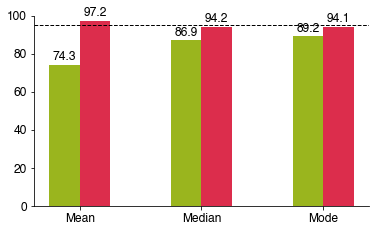

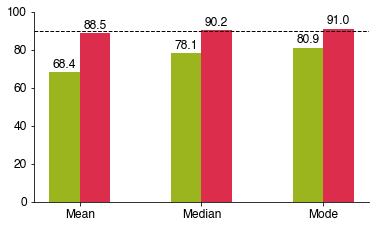

In [44]:
def plot_barchart(readingday,datatype,dataset,n_classifications):
    df=copy.deepcopy(CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==datatype) &\
                                       (CONSENSUS_SUMMARY.TRUTH_SET==dataset) &\
                                       (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                         (CONSENSUS_SUMMARY.GROWTH=='ALL') &\
                                         (CONSENSUS_SUMMARY.DRUG=='ALL') &\
                                       (CONSENSUS_SUMMARY.READINGDAY==readingday) &\
                                        (CONSENSUS_SUMMARY.N_CLASSIFICATIONS==n_classifications)] )

    df.rename(columns={'ESSENTIAL_AGREEMENT':'Essential agreement',\
                       'EXACT_AGREEMENT':'Exact agreement',\
                       'METHOD':'Method'},inplace=True)
    df['Method']=df['Method'].str.lower()
    df=df[['Method','Exact agreement','Essential agreement']].groupby('Method').mean()

    fig,axes=plt.subplots(1,1,figsize=(6,3.5))
    x=numpy.arange(3)
    width=0.25
    rects1=axes.bar(x-width/2,df['Exact agreement'],color=bashthebug_colours['green'],width=width)
    rects2=axes.bar(x+width/2,df['Essential agreement'],color=bashthebug_colours['red'],width=width)
    axes.set_xticks(x)
    axes.set_xticklabels(['Mean','Median','Mode'])
    x_range=axes.get_xlim()
    if datatype=='REPRODUCIBILITY':
        axes.plot(x_range,(95,95),'k--',lw=1)
    else:
        axes.plot(x_range,(90,90),'k--',lw=1)
    axes.set_xlim(x_range)
    axes.set_ylim((0,100))
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            axes.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.1f' % height,
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.savefig('pdf/'+str(readingday)+'/'+datatype.lower()+'/'+dataset.lower()+'/'+str(n_classifications)+'/bar-'+str(readingday)+'-'+datatype.lower()+'-'+dataset.lower()+'-'+str(n_classifications)+'.pdf')
    
    if dataset=='TRUTH_SET_3' and n_classifications==17:
        pass
    else:
        plt.close()
    
plot_barchart(14,'REPRODUCIBILITY','TRUTH_SET_3',17)
plot_barchart(14,'REPRODUCIBILITY','TRUTH_SET_1',17)
plot_barchart(14,'REPRODUCIBILITY','TRUTH_SET_3',5)
plot_barchart(14,'REPRODUCIBILITY','TRUTH_SET_3',11)

plot_barchart(14,'ACCURACY','TRUTH_SET_3',17)
plot_barchart(14,'ACCURACY','TRUTH_SET_1',17)

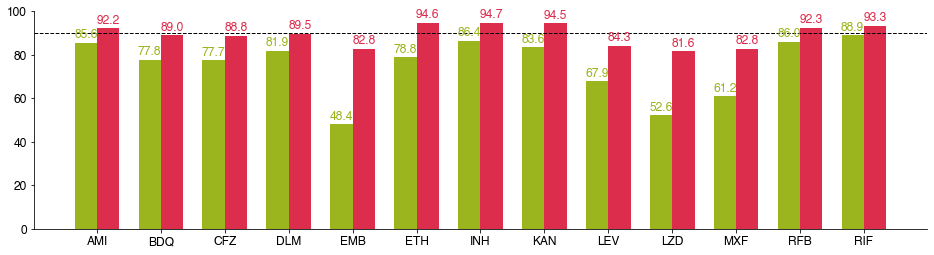

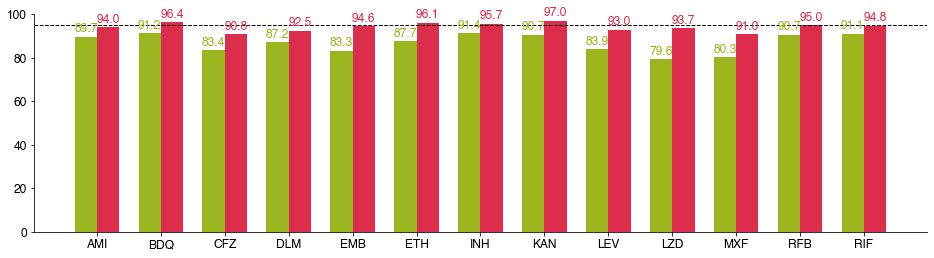

In [45]:
def plot_barchart_drugs(readingday,datatype,dataset,n_classifications,method):

    drugs=list(CONSENSUS_SUMMARY.DRUG.unique())
    if 'ALL' in drugs:
        drugs.remove('ALL')
    if 'PAS' in drugs:
        drugs.remove('PAS')    
    
    df=copy.deepcopy(CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==datatype) &\
                                           (CONSENSUS_SUMMARY.TRUTH_SET==dataset) &\
                                           (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                           (CONSENSUS_SUMMARY.METHOD==method) &\
                                            (CONSENSUS_SUMMARY.GROWTH=='ALL') &\
                                            (CONSENSUS_SUMMARY.DRUG.isin(drugs)) &\
                                            (CONSENSUS_SUMMARY.READINGDAY==readingday) &\
                                            (CONSENSUS_SUMMARY.N_CLASSIFICATIONS==n_classifications)] )
    df.rename(columns={'ESSENTIAL_AGREEMENT':'Essential agreement',\
                       'EXACT_AGREEMENT':'Exact agreement',\
                       'DRUG':'Drug'},inplace=True)
    df=df[['Drug','Exact agreement','Essential agreement']].groupby('Drug').mean()

    fig,axes=plt.subplots(1,1,figsize=(16,4))
    x=numpy.arange(len(drugs))
    width=0.35
    rects1=axes.bar(x-width/2,df['Exact agreement'],color=bashthebug_colours['green'],width=width)
    rects2=axes.bar(x+width/2,df['Essential agreement'],color=bashthebug_colours['red'],width=width)
    axes.set_xticks(x)
    axes.set_xticklabels(drugs)
    x_range=axes.get_xlim()
    if datatype=='REPRODUCIBILITY':
        axes.plot(x_range,(95,95),'k--',lw=1)
    else:
        axes.plot(x_range,(90,90),'k--',lw=1)
    axes.set_xlim(x_range)
    axes.set_ylim((0,100))
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

    def autolabel(rects,color):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            axes.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.1f' % height,
                    ha='center', va='bottom',color=color)

    autolabel(rects1,bashthebug_colours['green'])
    autolabel(rects2,bashthebug_colours['red'])

    fig.savefig('pdf/'+str(readingday)+'/'+datatype.lower()+'/'+dataset.lower()+'/'+str(n_classifications)+'/bar-'+str(readingday)+'-'+datatype.lower()+'-'+dataset.lower()+'-'+str(n_classifications)+'-'+method.lower()+'-drugs.pdf')
    
    if dataset=='TRUTH_SET_3' and n_classifications==17 and method=='MEDIAN':
        pass
    else:
        plt.close()

plot_barchart_drugs(14,'ACCURACY','TRUTH_SET_3',17,'MEDIAN')
plot_barchart_drugs(14,'REPRODUCIBILITY','TRUTH_SET_3',17,'MEDIAN')

plot_barchart_drugs(14,'ACCURACY','TRUTH_SET_3',17,'MEAN')
plot_barchart_drugs(14,'REPRODUCIBILITY','TRUTH_SET_3',17,'MEAN')

plot_barchart_drugs(14,'ACCURACY','TRUTH_SET_3',17,'MODE')
plot_barchart_drugs(14,'REPRODUCIBILITY','TRUTH_SET_3',17,'MODE')

## Table S5: reproducibility

In [46]:
df=copy.deepcopy(CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE=='REPRODUCIBILITY') &\
                                       (CONSENSUS_SUMMARY.TRUTH_SET=='TRUTH_SET_3') &\
                                       (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                         (CONSENSUS_SUMMARY.GROWTH=='ALL') &\
                                         (CONSENSUS_SUMMARY.DRUG=='ALL') &\
                                        (CONSENSUS_SUMMARY.N_CLASSIFICATIONS<=17)] )

df.replace({'METHOD':{'MEDIAN':'Median','MEAN':'Mean','MODE':'Mode'}},inplace=True)
df.rename(columns={'N_CLASSIFICATIONS':'Number of classifications'},inplace=True)


pivot=df.pivot(index=['Number of classifications','READINGDAY','BOOTSTRAP_RUN'],\
            columns='METHOD',\
            values=['INNER_SQUARE','EXACT_AGREEMENT','ESSENTIAL_AGREEMENT'])
pivot.reset_index(inplace=True)

table=pivot[[('Number of classifications',''),('READINGDAY',''),('INNER_SQUARE','Mean'),('EXACT_AGREEMENT','Mean'),\
                             ('EXACT_AGREEMENT','Median'),\
                             ('EXACT_AGREEMENT','Mode'),\
                             ('ESSENTIAL_AGREEMENT','Mean'),\
                             ('ESSENTIAL_AGREEMENT','Median'),\
                             ('ESSENTIAL_AGREEMENT','Mode')]]\
.groupby([('READINGDAY',''),('Number of classifications','')]).agg([numpy.mean,stats.sem])    

def return_formatted_values(row):
    tmp=[]
    tmp.append("%.1f $\pm$ %.1f "% (row[('INNER_SQUARE','Mean','mean')],row[('INNER_SQUARE','Mean','sem')]))
    for j in ['EXACT_AGREEMENT','ESSENTIAL_AGREEMENT']:
        for i in ['Mean','Median','Mode']:
            tmp.append("%.1f $\pm$ %.1f "% (row[(j,i,'mean')],row[(j,i,'sem')]))
    return(pandas.Series(tmp))

table=copy.deepcopy(table.apply(return_formatted_values,axis=1))
table.index.names=['Reading day','$n$']
tuples=[('Prop. with','MIC (\%)'),('Exact Agreement (\%)','Mean'),('Exact Agreement (\%)','Median'),('Exact Agreement (\%)','Mode'),('Essential Agreement (\%)','Mean'),('Essential Agreement (\%)','Median'),('Essential Agreement (\%)','Mode')]
table.columns=pandas.MultiIndex.from_tuples(tuples)


print("\\begin{table}\n\\begin{center}")
print(table.to_latex(index=True,\
                     escape=False,\
                     column_format='rr|p{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}',\
                     multicolumn_format='c',\
                     multirow=True).rstrip())
print("\\caption[The effect on reproducibility of varying the number of days incubated, the number of classifications and the consensus method.]{\\label{table:S4} The effect on reproducibility of varying the number of days incubated, the number of classifications, $n$, and the consensus method. The standard error of the mean is given.}")
print("\\end{center}\n\\end{table}\n")


\begin{table}
\begin{center}
\begin{tabular}{rr|p{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}}
\toprule
   &    &       Prop. with & \multicolumn{3}{c}{Exact Agreement (\%)} & \multicolumn{3}{c}{Essential Agreement (\%)} \\
   &    &         MIC (\%) &                 Mean &           Median &             Mode &                     Mean &           Median &             Mode \\
Reading day & $n$ &                  &                      &                  &                  &                          &                  &                  \\
\midrule
\multirow{9}{*}{7} & 1  &  62.6 $\pm$ 0.1  &      68.6 $\pm$ 0.1  &  68.6 $\pm$ 0.1  &  68.6 $\pm$ 0.1  &          82.6 $\pm$ 0.1  &  82.6 $\pm$ 0.1  &  82.6 $\pm$ 0.1  \\
   & 3  &  69.3 $\pm$ 0.1  &      61.7 $\pm$ 0.1  &  71.6 $\pm$ 0.1  &  75.2 $\pm$ 0.1  &          84.3 $\pm$ 0.1  &  86.0 $\pm$ 0.1  &  86.9 $\pm$ 0.1  \\
   & 5  &  71.8 $\pm$ 0.1  &      63.3 $\pm$ 0.1  &  76.9 $\pm$ 0.1  &  79.4 $\pm$ 0.1  &          89.5 

# Table S6: accuracy

In [47]:
df=copy.deepcopy(CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE=='ACCURACY') &\
                                       (CONSENSUS_SUMMARY.TRUTH_SET=='TRUTH_SET_3') &\
                                       (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                       (CONSENSUS_SUMMARY.GROWTH=='ALL') &\
                                       (CONSENSUS_SUMMARY.DRUG=='ALL') &\
                                       (CONSENSUS_SUMMARY.N_CLASSIFICATIONS<=17) &\
                                       (CONSENSUS_SUMMARY.N_CLASSIFICATIONS>1) ])

df.replace({'METHOD':{'MEDIAN':'Median','MEAN':'Mean','MODE':'Mode'}},inplace=True)
df.rename(columns={'N_CLASSIFICATIONS':'Number of classifications'},inplace=True)


pivot=df.pivot(index=['Number of classifications','READINGDAY','BOOTSTRAP_RUN'],\
            columns='METHOD',\
            values=['PROP_READ','EXACT_AGREEMENT','ESSENTIAL_AGREEMENT'])
pivot.reset_index(inplace=True)

table=pivot[[('Number of classifications',''),('READINGDAY',''),('PROP_READ','Mean'),('EXACT_AGREEMENT','Mean'),\
                             ('EXACT_AGREEMENT','Median'),\
                             ('EXACT_AGREEMENT','Mode'),\
                             ('ESSENTIAL_AGREEMENT','Mean'),\
                             ('ESSENTIAL_AGREEMENT','Median'),\
                             ('ESSENTIAL_AGREEMENT','Mode')]]\
.groupby([('READINGDAY',''),('Number of classifications','')]).agg([numpy.mean,stats.sem])    

def return_formatted_values(row):
    tmp=[]
    tmp.append("%.1f $\pm$ %.1f "% (row[('PROP_READ','Mean','mean')],row[('PROP_READ','Mean','sem')]))
    for j in ['EXACT_AGREEMENT','ESSENTIAL_AGREEMENT']:
        for i in ['Mean','Median','Mode']:
            tmp.append("%.1f $\pm$ %.1f "% (row[(j,i,'mean')],row[(j,i,'sem')]))
    return(pandas.Series(tmp))

table=copy.deepcopy(table.apply(return_formatted_values,axis=1))
table.index.names=['Reading day','$n$']
tuples=[('Prop. with','MIC (\%)'),('Exact Agreement (\%)','Mean'),('Exact Agreement (\%)','Median'),('Exact Agreement (\%)','Mode'),('Essential Agreement (\%)','Mean'),('Essential Agreement (\%)','Median'),('Essential Agreement (\%)','Mode')]
table.columns=pandas.MultiIndex.from_tuples(tuples)

print("\\begin{table}\n\\begin{center}")
print(table.to_latex(index=True,\
                     escape=False,\
                     column_format='rr|p{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}',\
                     multicolumn_format='c',\
                     multirow=True).rstrip())
print("\\caption[The effect on accuracy of varying the number of days incubated, the number of classifications and the consensus method.]{\\label{table:S4} The effect on accuracy of varying the number of days incubated, the number of classifications, $n$, and the consensus method. The standard error of the mean is given.}")
print("\\end{center}\n\\end{table}\n")


\begin{table}
\begin{center}
\begin{tabular}{rr|p{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}}
\toprule
   &    &       Prop. with & \multicolumn{3}{c}{Exact Agreement (\%)} & \multicolumn{3}{c}{Essential Agreement (\%)} \\
   &    &         MIC (\%) &                 Mean &           Median &             Mode &                     Mean &           Median &             Mode \\
Reading day & $n$ &                  &                      &                  &                  &                          &                  &                  \\
\midrule
\multirow{8}{*}{7} & 3  &  78.0 $\pm$ 0.1  &      67.6 $\pm$ 0.2  &  69.1 $\pm$ 0.2  &  74.0 $\pm$ 0.2  &          84.0 $\pm$ 0.1  &  85.8 $\pm$ 0.1  &  89.4 $\pm$ 0.1  \\
   & 5  &  78.5 $\pm$ 0.1  &      67.3 $\pm$ 0.1  &  70.1 $\pm$ 0.1  &  73.5 $\pm$ 0.1  &          86.5 $\pm$ 0.1  &  87.3 $\pm$ 0.1  &  89.2 $\pm$ 0.1  \\
   & 7  &  78.9 $\pm$ 0.1  &      67.9 $\pm$ 0.2  &  70.3 $\pm$ 0.1  &  73.7 $\pm$ 0.1  &          87.4 

# Table S7, S8: Does halting at n=3 improve matters?

In [57]:
def return_weighted_value(a,b,column):
    a_x=float(a[column])
    b_x=float(b[column])
    a_n=float(a['N'])
    b_n=float(b['N'])
    value=(((a_x*a_n)+(b_x*b_n))/(a_n+b_n))
    return(value)


for metric in ['REPRODUCIBILITY','ACCURACY']:

    table=[]

    for reading_day in [14]:

        df=CONDENSED_SUMMARY.loc[ (CONDENSED_SUMMARY.READINGDAY==reading_day) &\
                                  (CONDENSED_SUMMARY.GROWTH=='ALL') &\
                                  (CONDENSED_SUMMARY.DRUG=='ALL') &\
                                  (CONDENSED_SUMMARY.TRUTH_SET=='TRUTH_SET_3') &\
                                  (CONDENSED_SUMMARY.TYPE==metric)  ]

        zero_rows=copy.deepcopy(df.loc[(df.N_CLASSIFICATIONS==3) & (df.STDDEV=='ZERO')])

        for n in [3,5,7,9,11,13,15,17]:

            line=[]
            line.append(reading_day)

            non_zero_rows=df.loc[(df.N_CLASSIFICATIONS==n) & (df.STDDEV=='NOT_ZERO')]

            line.append(n)

            for method in ['MEAN','MEDIAN','MODE']:

                a=zero_rows.loc[zero_rows.METHOD==method]       
                b=non_zero_rows.loc[non_zero_rows.METHOD==method]

                if method=='MEAN':
                    line.append(return_weighted_value(a,b,'N_CLASSIFICATIONS'))

                    line.append(return_weighted_value(a,b,'PROP_READ'))

                diagonal=return_weighted_value(a,b,'DIAGONAL')
                inner_square=return_weighted_value(a,b,'INNER_SQUARE')

                line.append(100*diagonal/inner_square)

            for method in ['MEAN','MEDIAN','MODE']:

                a=zero_rows.loc[zero_rows.METHOD==method]       
                b=non_zero_rows.loc[non_zero_rows.METHOD==method]

                diagonal=return_weighted_value(a,b,'DIAGONAL')
                inner_square=return_weighted_value(a,b,'INNER_SQUARE')
                upper_diagonal=return_weighted_value(a,b,'UPPER_DIAGONAL')
                lower_diagonal=return_weighted_value(a,b,'LOWER_DIAGONAL')        

                line.append(100*(upper_diagonal+diagonal+lower_diagonal)/inner_square)

            table.append(line)

    table=pandas.DataFrame(table,columns=['Reading day','$n$','av N','prop','X1','X2','X3','M1','M2','M3'])

    table.set_index(['Reading day','$n$'],inplace=True)

    table.columns=pandas.MultiIndex.from_tuples([('Average','$n$'),('Prop. with','MIC (\%)'),('Exact Agreement (\%)','Mean'),('Exact Agreement (\%)','Median'),('Exact Agreement (\%)','Mode'),('Essential Agreement (\%)','Mean'),('Essential Agreement (\%)','Median'),('Essential Agreement (\%)','Mode')])

    print("\\begin{table}\n\\begin{center}")
    print(table.to_latex(index=True,\
                        float_format='%.1f',\
                         escape=False,\
                         column_format='rr|rp{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}',\
                         multicolumn_format='c',\
                         multirow=True).rstrip() )
    
    if metric=='REPRODUCIBILITY':
        print("\\caption[Reproducibility when applying early halting]{\\label{table:S7} The effect on reproducibility of dynamically retiring images if the first three classifications are identical and continuing the remainder until they have accrued $n$ classifications.}") 
    else:
        print("\\caption[Accuracy when applying early halting]{\\label{table:S8} The effect on accuracy of dynamically retiring images if the first three classifications are identical and continuing the remainder until they have accrued $n$ classifications.}") 
    print("\\end{center}\n\\end{table}\n")


\begin{table}
\begin{center}
\begin{tabular}{rr|rp{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}}
\toprule
   &    & Average & Prop. with & \multicolumn{3}{c}{Exact Agreement (\%)} & \multicolumn{3}{c}{Essential Agreement (\%)} \\
   &    &     $n$ &   MIC (\%) &                 Mean & Median & Mode &                     Mean & Median & Mode \\
Reading day & $n$ &         &            &                      &        &      &                          &        &      \\
\midrule
\multirow{8}{*}{14} & 3  &     3.0 &       95.1 &                 81.4 &   79.1 & 81.7 &                     92.6 &   89.3 & 90.4 \\
   & 5  &     3.9 &       96.6 &                 79.0 &   82.7 & 84.4 &                     93.1 &   91.4 & 91.6 \\
   & 7  &     4.7 &       97.1 &                 80.0 &   83.6 & 85.7 &                     94.4 &   92.1 & 92.1 \\
   & 9  &     5.6 &       97.4 &                 80.8 &   84.6 & 86.6 &                     95.3 &   92.8 & 92.7 \\
   & 11 &     6.5 &       

# Table S9: Agreement between Expert and BashTheBug by dilution

In [50]:
df=CONSENSUS_DATASET.loc[ (CONSENSUS_DATASET.READINGDAY==14)]

df['MEDIAN_XA']=df['MEDIAN']==df['TRUTH_SET_1']
df['MEDIAN_CEIL']=numpy.ceil(df['MEDIAN'])

df['MEDIAN_EA']=(df.MEDIAN_CEIL<=df['TRUTH_SET_1']+1) & (df.MEDIAN_CEIL>=df['TRUTH_SET_1']-1)

table=copy.deepcopy(df[['MEDIAN_CEIL','MEDIAN_XA']].groupby('MEDIAN_CEIL').agg([numpy.mean,stats.sem]))
table.columns=table.columns.droplevel()
def return_formatted_values(row):
    return("%.1f $\pm$ %.1f %%"% (100*row[('mean')],100*row[('sem')]))
table[['Agreement']]=table.apply(return_formatted_values,axis=1)
table.reset_index(inplace=True)
table
table.rename(columns={'MEDIAN_CEIL':'Dilution'},inplace=True)
table.Dilution=table.Dilution.astype(int)
table.replace({'Dilution':{0:'NR'}},inplace=True)
table=table[['Dilution','Agreement']]

print("\\begin{table}\n\\begin{center}")
print(table.to_latex(float_format='%.1f %',\
                     column_format='r|r',\
               escape=False,\
               index=False).rstrip())
print("\\caption[The Expert and BashTheBug MICs are more likely to concur at smaller dilutions. ]{\\label{table:S4} The Expert and BashTheBug MICs are more likely to concur at smaller dilutions. The BashTheBug consensus measurement was built by taking the median of 17 classifications and rounding up if a non-integer was returned. The standard error of the mean is given.}")
print("\\end{center}\n\\end{table}\n")


<ipython-input-50-6f20ccfe4653>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MEDIAN_XA']=df['MEDIAN']==df['TRUTH_SET_1']
<ipython-input-50-6f20ccfe4653>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MEDIAN_CEIL']=numpy.ceil(df['MEDIAN'])
<ipython-input-50-6f20ccfe4653>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

\begin{table}
\begin{center}
\begin{tabular}{r|r}
\toprule
Dilution &        Agreement \\
\midrule
      NR & 20.0 $\pm$ 0.1 % \\
       1 & 83.9 $\pm$ 0.1 % \\
       2 & 72.0 $\pm$ 0.1 % \\
       3 & 66.6 $\pm$ 0.1 % \\
       4 & 48.2 $\pm$ 0.1 % \\
       5 & 53.4 $\pm$ 0.1 % \\
       6 & 52.6 $\pm$ 0.1 % \\
       7 & 42.8 $\pm$ 0.1 % \\
       8 & 46.7 $\pm$ 0.1 % \\
       9 & 21.1 $\pm$ 0.2 % \\
\bottomrule
\end{tabular}
\caption[The Expert and BashTheBug MICs are more likely to concur at smaller dilutions.]{\label{table:S4} The Expert and BashTheBug MICs are more likely to concur at smaller dilutions. The BashTheBug consensus measurement was built by taking the median of 17 classifications and rounding up if a non-integer was returned.}
\end{center}
\end{table}



## Fig 5, SX. Combined graphs (incl. growth)

In [51]:
methods=['mean','median','mode']

for dataset_type in tqdm(['reproducibility','accuracy']):

    for truth_set in tqdm(['truth_set_3','truth_set_2','truth_set_1']):

        for reading_day in [7,10,14,21]:

            for growth in ['ALL','HIGH','MEDIUM','LOW']:

                fig,axes=plt.subplots(1,4,figsize=(18,4),sharey=True)
                
                fig.subplots_adjust(wspace=0)

                # subset out the rows we want
                df2=CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==dataset_type.upper()) &\
                                         (CONSENSUS_SUMMARY.TRUTH_SET==truth_set.upper()) &\
                                         (CONSENSUS_SUMMARY.METHOD=='MEAN') &\
                                         (CONSENSUS_SUMMARY.READINGDAY==reading_day) &\
                                         (CONSENSUS_SUMMARY.GROWTH==growth) &\
                                         (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                         (CONSENSUS_SUMMARY.DRUG=='ALL')]
                if not df2.empty:
                    # aggregate over the bootstrapped runs
                    df=df2[['N_CLASSIFICATIONS','PROP_READ']].groupby(['N_CLASSIFICATIONS']).agg([numpy.mean,stats.sem])                
                    axes[0].plot(df[('PROP_READ','mean')],color='black')
                    axes[0].plot(df[('PROP_READ','mean')]+1.96*df['PROP_READ','sem'],color='black',alpha=0.5)
                    axes[0].plot(df[('PROP_READ','mean')]-1.96*df['PROP_READ','sem'],color='black',alpha=0.5)
                    axes[0].set_ylim([0,100])
                    axes[0].set_xlim([3,17])
                    axes[0].set_xticks(df.index[:-3])
                    axes[0].grid()
                    
                for i in [1,2,3]:

                    # subset out the rows we want
                    df2=CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==dataset_type.upper()) &\
                                             (CONSENSUS_SUMMARY.TRUTH_SET==truth_set.upper()) &\
                                             (CONSENSUS_SUMMARY.METHOD==methods[i-1].upper()) &\
                                             (CONSENSUS_SUMMARY.READINGDAY==reading_day) &\
                                             (CONSENSUS_SUMMARY.GROWTH==growth) &\
                                             (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                             (CONSENSUS_SUMMARY.DRUG=='ALL')]
                    if not df2.empty:

                        # aggregate over the bootstrapped runs
                        df=df2[['N_CLASSIFICATIONS','ESSENTIAL_AGREEMENT','EXACT_AGREEMENT']].groupby(['N_CLASSIFICATIONS']).agg([numpy.mean,stats.sem])

                        axes[i].plot(df[('ESSENTIAL_AGREEMENT','mean')],color=bashthebug_colours['red'])
                        axes[i].plot(df[('ESSENTIAL_AGREEMENT','mean')]+1.96*df['ESSENTIAL_AGREEMENT','sem'],color=bashthebug_colours['red'],alpha=0.5)
                        axes[i].plot(df[('ESSENTIAL_AGREEMENT','mean')]-1.96*df['ESSENTIAL_AGREEMENT','sem'],color=bashthebug_colours['red'],alpha=0.5)
                        axes[i].plot(df[('EXACT_AGREEMENT','mean')],color=bashthebug_colours['green'])
                        axes[i].plot(df[('EXACT_AGREEMENT','mean')]+1.96*df['EXACT_AGREEMENT','sem'],color=bashthebug_colours['green'],alpha=0.5)
                        axes[i].plot(df[('EXACT_AGREEMENT','mean')]-1.96*df['EXACT_AGREEMENT','sem'],color=bashthebug_colours['green'],alpha=0.5)
                        axes[i].set_ylim([0,100])
                        if i==3:
                            axes[i].set_xticks(df.index[:-2])
                        else:
                            axes[i].set_xticks(df.index[:-3])

                        axes[i].grid()
                        if dataset_type=='reproducibility':
                            axes[i].plot((3,17),(95,95),color='black',linestyle='--')                
                        else:
                            axes[i].plot((3,17),(90,90),color='black',linestyle='--')

                        axes[i].set_xlim([3,17])
                        
                    if growth=='ALL':
                        path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / dataset_type / truth_set /  'all' 
                    else:
                        path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / dataset_type / truth_set /  'all' / growth.lower()
                        
                    path.mkdir(parents=True,exist_ok=True)
                    filename = 'summary-'+str(reading_day)+'-'+dataset_type+'-'+truth_set+'-growth-'+growth.lower()+'-combined.pdf'                    

                    fig.savefig(path / filename ,bbox_inches=0)

                    if reading_day==14 and dataset_type in ['reproducibility'] and growth=='ALL':
                        continue

                    plt.close()



100%|██████████| 2/2 [01:05<00:00, 32.80s/it]


## Fig SX. Separate graphs

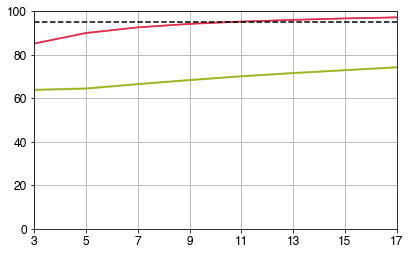

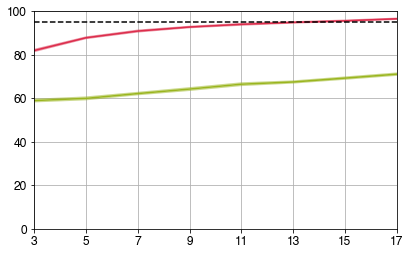

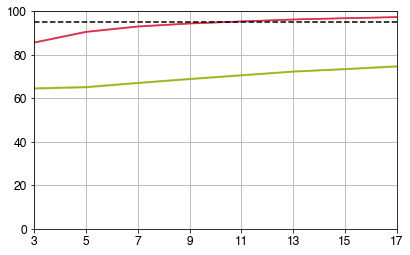

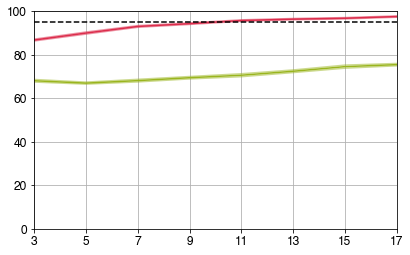

In [52]:
for dataset_type in ['reproducibility','accuracy']:
    
    for truth_set in ['truth_set_1','truth_set_2','truth_set_3']:
    
        for reading_day in [7,10,14,21]:

            for growth in ['ALL','HIGH','MEDIUM','LOW']:

                for method in ['mean','median','mode']:

                    # subset out the rows we want
                    df=CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==dataset_type.upper()) &\
                                             (CONSENSUS_SUMMARY.TRUTH_SET==truth_set.upper()) &\
                                             (CONSENSUS_SUMMARY.METHOD==method.upper()) &\
                                             (CONSENSUS_SUMMARY.READINGDAY==reading_day) &\
                                             (CONSENSUS_SUMMARY.GROWTH==growth) &\
                                             (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                             (CONSENSUS_SUMMARY.DRUG=='ALL') ]

                    # aggregate over the bootstrapped runs
                    df=df[['N_CLASSIFICATIONS','ESSENTIAL_AGREEMENT','EXACT_AGREEMENT']].groupby(['N_CLASSIFICATIONS']).agg([numpy.mean,stats.sem])

                    fig,axes=plt.subplots(1,1,figsize=(6.5,4))
                    axes.plot(df[('ESSENTIAL_AGREEMENT','mean')],color=bashthebug_colours['red'])
                    axes.plot(df[('ESSENTIAL_AGREEMENT','mean')]+1.96*df['ESSENTIAL_AGREEMENT','sem'],color=bashthebug_colours['red'],alpha=0.5)
                    axes.plot(df[('ESSENTIAL_AGREEMENT','mean')]-1.96*df['ESSENTIAL_AGREEMENT','sem'],color=bashthebug_colours['red'],alpha=0.5)
                    axes.plot(df[('EXACT_AGREEMENT','mean')],color=bashthebug_colours['green'])
                    axes.plot(df[('EXACT_AGREEMENT','mean')]+1.96*df['EXACT_AGREEMENT','sem'],color=bashthebug_colours['green'],alpha=0.5)
                    axes.plot(df[('EXACT_AGREEMENT','mean')]-1.96*df['EXACT_AGREEMENT','sem'],color=bashthebug_colours['green'],alpha=0.5)
                    axes.set_ylim([0,100])
    #                 axes.set_ylabel('Percentage')
    #                 axes.set_xlabel('Number of classifications in consensus')
                    axes.set_xticks(df.index)
                    axes.grid()
                    axes.set_xlim([3,17])
                    if dataset_type=='reproducibility':
                        axes.plot((3,17),(95,95),color='black',linestyle='--')                
                    else:
                        axes.plot((3,17),(90,90),color='black',linestyle='--')

                    if growth=='ALL':
                        path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / dataset_type / truth_set / 'all' 
                    else:
                        path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / dataset_type / truth_set / 'all' / growth.lower()
                        
                    path.mkdir(parents=True,exist_ok=True)
                    filename = 'summary-'+str(reading_day)+'-'+dataset_type+'-'+truth_set+'-growth-'+growth.lower()+'-'+method+'.pdf'

                    fig.savefig(path / filename ,bbox_inches=0)

                    if reading_day==14 and dataset_type in ['reproducibility'] and method=='mean' and truth_set=='truth_set_3':
                        continue

                    plt.close()


## Fig SXX. By drug

100%|██████████| 2/2 [00:14<00:00,  7.15s/it]


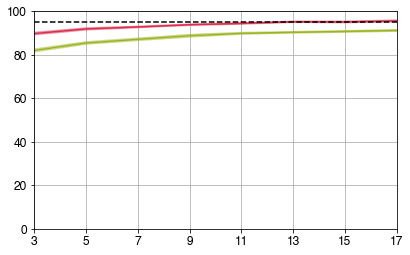

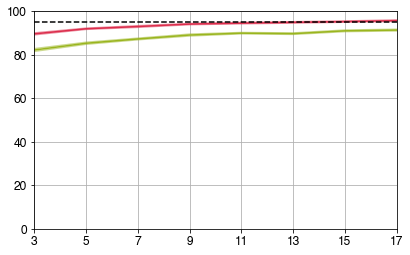

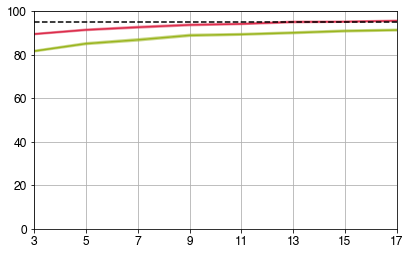

In [53]:
for dataset_type in tqdm(['reproducibility','accuracy']):
    
    for truth_set in tqdm(['truth_set_1','truth_set_2','truth_set_3']):
    
        for reading_day in [14]:

            for drug in ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'PAS', 'RFB', 'RIF']:

                for method in ['median']:

                    # subset out the rows we want
                    df=CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==dataset_type.upper()) &\
                                             (CONSENSUS_SUMMARY.TRUTH_SET==truth_set.upper()) &\
                                             (CONSENSUS_SUMMARY.METHOD==method.upper()) &\
                                             (CONSENSUS_SUMMARY.READINGDAY==reading_day) &\
                                             (CONSENSUS_SUMMARY.GROWTH=='ALL') &\
                                             (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                             (CONSENSUS_SUMMARY.DRUG==drug) ]

                    # aggregate over the bootstrapped runs
                    df=df[['N_CLASSIFICATIONS','ESSENTIAL_AGREEMENT','EXACT_AGREEMENT']].groupby(['N_CLASSIFICATIONS']).agg([numpy.mean,stats.sem])

                    fig,axes=plt.subplots(1,1,figsize=(6.5,4))
                    axes.plot(df[('ESSENTIAL_AGREEMENT','mean')],color=bashthebug_colours['red'])
                    axes.plot(df[('ESSENTIAL_AGREEMENT','mean')]+1.96*df['ESSENTIAL_AGREEMENT','sem'],color=bashthebug_colours['red'],alpha=0.5)
                    axes.plot(df[('ESSENTIAL_AGREEMENT','mean')]-1.96*df['ESSENTIAL_AGREEMENT','sem'],color=bashthebug_colours['red'],alpha=0.5)
                    axes.plot(df[('EXACT_AGREEMENT','mean')],color=bashthebug_colours['green'])
                    axes.plot(df[('EXACT_AGREEMENT','mean')]+1.96*df['EXACT_AGREEMENT','sem'],color=bashthebug_colours['green'],alpha=0.5)
                    axes.plot(df[('EXACT_AGREEMENT','mean')]-1.96*df['EXACT_AGREEMENT','sem'],color=bashthebug_colours['green'],alpha=0.5)
                    axes.set_ylim([0,100])
    #                 axes.set_ylabel('Percentage')
    #                 axes.set_xlabel('Number of classifications in consensus')
                    axes.set_xticks(df.index)
                    axes.grid()
                    axes.set_xlim([3,17])
                    if dataset_type=='reproducibility':
                        axes.plot((3,17),(95,95),color='black',linestyle='--')                
                    else:
                        axes.plot((3,17),(90,90),color='black',linestyle='--')

                    path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / dataset_type / truth_set / 'all' 
                        
                    path.mkdir(parents=True,exist_ok=True)
                    filename = 'summary-'+str(reading_day)+'-'+dataset_type+'-'+truth_set+'-growth-all-'+method+'-'+drug+'.pdf'

                    fig.savefig(path / filename ,bbox_inches=0)

                    if reading_day==14 and dataset_type in ['reproducibility'] and method=='median' and drug=='INH':
                        continue

                    plt.close()
